## Imports

In [ ]:
!pip install sentence_transformers
!pip install torch_geometric

In [18]:
import warnings
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from google.colab import files
import gc

from dataset_dataloader import IMCAG, GraphDataLoader
from models import ARMANet, FeaStNet, GATNet, GCN, RGGCN, UniMP

import torch
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")

In [ ]:
path = os.getcwd()

In [ ]:
os.mkdir(os.path.join(path, 'pretrained_models'))
os.mkdir(os.path.join(path, 'images'))

## Load dataset

In [ ]:
dataset = IMCAG('data/')

In [ ]:
with open('test_indices.txt', 'r') as f:
    lines = f.readlines()
    test_indices = list(map(int, lines[0].strip().split()))

all_indices = np.arange(len(dataset))
train_indices = np.setdiff1d(all_indices, test_indices)
len(dataset) == len(train_indices) + len(test_indices)

In [ ]:
train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

In [ ]:
train_loader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=torch.cuda.is_available())
test_loader = GraphDataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=torch.cuda.is_available())

In [ ]:
del dataset
gc.collect()

29

## Models

In [ ]:
num_epochs = 10

In [ ]:
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

device = torch.device(dev)

In [ ]:
def train():
    model.train()
    loss_sum = 0

    for i, data in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        loss_sum += loss.item() * len(data)
        loss.backward()
        optimizer.step()
        
    return  loss_sum / len(train_loader.sampler)

In [ ]:
def test(report_dict=True):
    model.eval()
    loss_sum, acc_sum = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            data = data.to(device)
            out = model(data)

            loss = criterion(out, data.y)
            loss_sum += loss.item() * len(data)

            pred = out.argmax(dim=1)
            y_true.append(data.y)
            y_pred.append(pred)
            acc_sum += int((pred == data.y).sum())

    y_true, y_pred = torch.hstack(y_true).to('cpu'), torch.hstack(y_pred).to('cpu')
    report = metrics.classification_report(y_true, y_pred, output_dict=report_dict)
    return loss_sum / len(test_loader.sampler), acc_sum / len(test_loader.sampler), report

In [ ]:
def train_model(name):
    epochs = num_epochs
    train_losses, test_losses = [], []

    for epoch in range(1, epochs + 1):
        train_loss = train()
        train_losses.append(train_loss)

        test_loss, test_acc, report = test()
        test_losses.append(test_loss)

        print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print()

        if epoch % 5 == 0:
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'test_losses': test_losses,
                'report': report}

            torch.save(state, os.path.join(path, f'pretrained_models/{name}_{num_epochs}_epochs.pt'))

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train")
    plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Average loss")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(path, f'images/{name}_{num_epochs}_epochs.png'))
    plt.show()

### GCN

In [ ]:
model = GCN(in_channels=768, hidden_channels=512, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 001, Train loss: 0.3786, Test loss: 0.3226, Test Acc: 0.8505



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 002, Train loss: 0.3204, Test loss: 0.2968, Test Acc: 0.8727



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 003, Train loss: 0.3008, Test loss: 0.2707, Test Acc: 0.8729



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 004, Train loss: 0.2785, Test loss: 0.2554, Test Acc: 0.9014



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 005, Train loss: 0.2764, Test loss: 0.2577, Test Acc: 0.9044



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 006, Train loss: 0.2736, Test loss: 0.2582, Test Acc: 0.9088



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 007, Train loss: 0.2697, Test loss: 0.2454, Test Acc: 0.8998



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 008, Train loss: 0.2628, Test loss: 0.2408, Test Acc: 0.9084



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 009, Train loss: 0.2557, Test loss: 0.2435, Test Acc: 0.9127



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 010, Train loss: 0.2516, Test loss: 0.2284, Test Acc: 0.9108



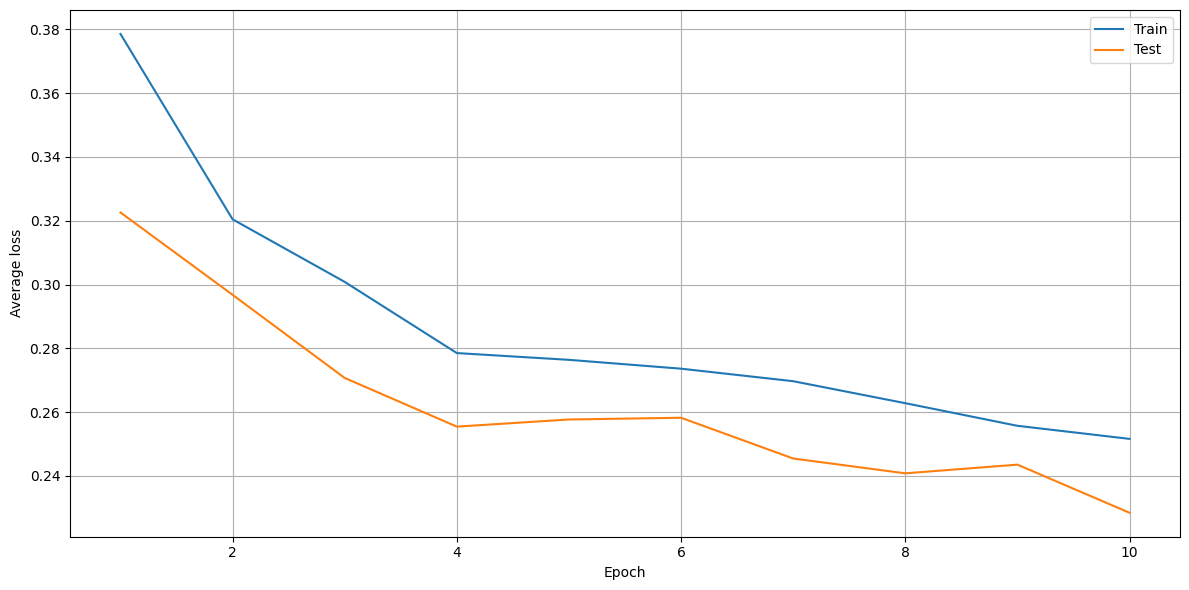

In [ ]:
train_model('GCN')

### FeaStNet

In [ ]:
model = FeaStNet(in_channels=768, hidden_channels=512, num_classes=2, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 001, Train loss: 0.3747, Test loss: 0.3153, Test Acc: 0.8861



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 002, Train loss: 0.3050, Test loss: 0.2738, Test Acc: 0.8867



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 003, Train loss: 0.2901, Test loss: 0.2712, Test Acc: 0.8676



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 004, Train loss: 0.2793, Test loss: 0.2622, Test Acc: 0.8904



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 005, Train loss: 0.2741, Test loss: 0.2542, Test Acc: 0.8727



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 006, Train loss: 0.2623, Test loss: 0.2500, Test Acc: 0.9039



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 007, Train loss: 0.2580, Test loss: 0.2411, Test Acc: 0.9050



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 008, Train loss: 0.2530, Test loss: 0.2375, Test Acc: 0.8827



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 009, Train loss: 0.2376, Test loss: 0.2247, Test Acc: 0.9077



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 010, Train loss: 0.2344, Test loss: 0.2235, Test Acc: 0.9058



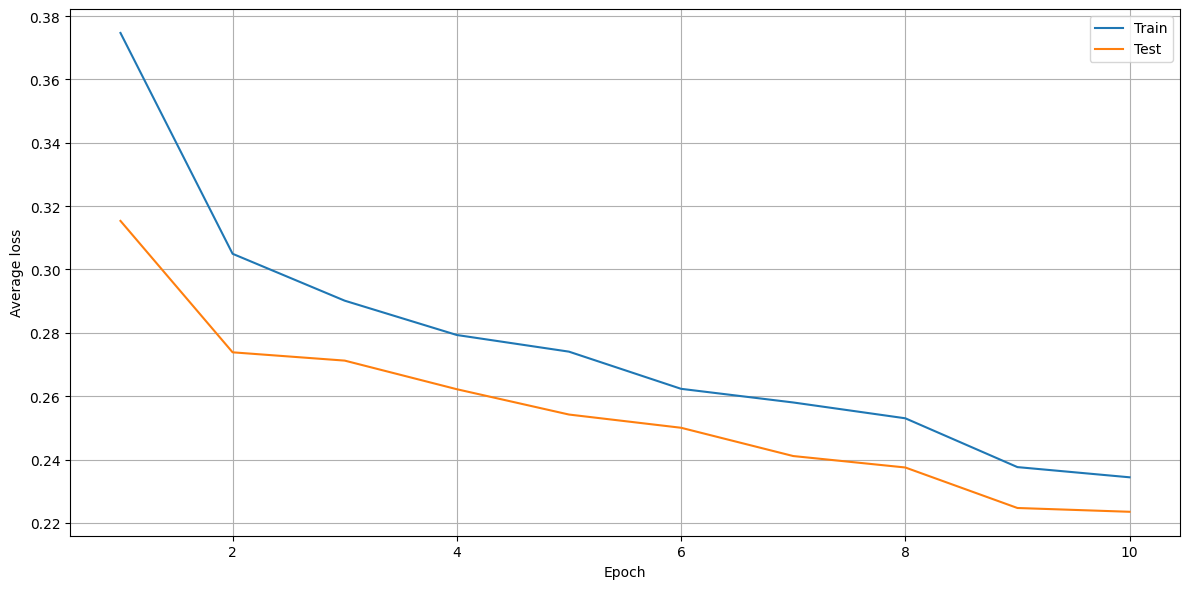

In [ ]:
train_model('FeaStNet')

### ARMAConv

In [ ]:
model = ARMANet(in_channels=768, hidden_channels=512, num_classes=2, num_stacks=2, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 001, Train loss: 0.3282, Test loss: 0.2617, Test Acc: 0.9021



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 002, Train loss: 0.2594, Test loss: 0.2389, Test Acc: 0.9013



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 003, Train loss: 0.2481, Test loss: 0.2285, Test Acc: 0.9076



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 004, Train loss: 0.2381, Test loss: 0.2257, Test Acc: 0.9099



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 005, Train loss: 0.2317, Test loss: 0.2223, Test Acc: 0.9094



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 006, Train loss: 0.2294, Test loss: 0.2269, Test Acc: 0.9060



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 007, Train loss: 0.2241, Test loss: 0.2224, Test Acc: 0.9083



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 008, Train loss: 0.2239, Test loss: 0.2225, Test Acc: 0.9029



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 009, Train loss: 0.2203, Test loss: 0.2257, Test Acc: 0.9098



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

Epoch: 010, Train loss: 0.2214, Test loss: 0.2160, Test Acc: 0.9091



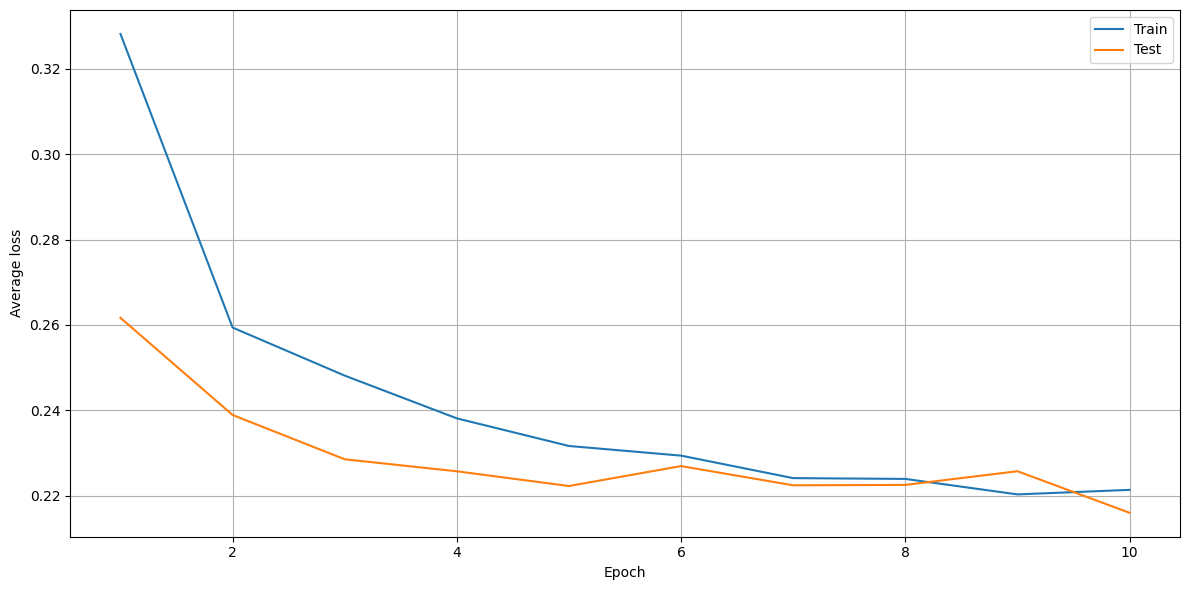

In [ ]:
train_model('ARMAConv')

### GATNet

In [ ]:
model = GATNet(in_channels=768, hidden_channels=512, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9501841676227281, 'recall': 0.9046797746349315, 'f1-score': 0.92687380356354, 'support': 17394}, '1': {'precision': 0.8167348292251575, 'recall': 0.8995617238860482, 'f1-score': 0.8561497016395342, 'support': 8214}, 'accuracy': 0.9030381130896595, 'macro avg': {'precision': 0.8834594984239428, 'recall': 0.9021207492604899, 'f1-score': 0.891511752601537, 'support': 25608}, 'weighted avg': {'precision': 0.9073790729024203, 'recall': 0.9030381130896595, 'f1-score': 0.9041884016108774, 'support': 25608}}
Epoch: 001, Train loss: 0.3591, Test loss: 0.3088, Test Acc: 0.9030



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9334691501746216, 'recall': 0.9219845923881799, 'f1-score': 0.927691328744143, 'support': 17394}, '1': {'precision': 0.8389890840056953, 'recall': 0.8608473338203068, 'f1-score': 0.8497776709530104, 'support': 8214}, 'accuracy': 0.9023742580443611, 'macro avg': {'precision': 0.8862291170901584, 'recall': 0.8914159631042433, 'f1-score': 0.8887344998485767, 'support': 25608}, 'weighted avg': {'precision': 0.9031638056138765, 'recall': 0.9023742580443611, 'f1-score': 0.9026998110505955, 'support': 25608}}
Epoch: 002, Train loss: 0.3049, Test loss: 0.2943, Test Acc: 0.9024



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9527206771463119, 'recall': 0.9059445785903185, 'f1-score': 0.928744032533742, 'support': 17394}, '1': {'precision': 0.819585355094839, 'recall': 0.9047966885804724, 'f1-score': 0.8600856382363152, 'support': 8214}, 'accuracy': 0.9055763823805061, 'macro avg': {'precision': 0.8861530161205755, 'recall': 0.9053706335853955, 'f1-score': 0.8944148353850286, 'support': 25608}, 'weighted avg': {'precision': 0.9100163060384239, 'recall': 0.9055763823805061, 'f1-score': 0.9067212251782647, 'support': 25608}}
Epoch: 003, Train loss: 0.2973, Test loss: 0.2862, Test Acc: 0.9056



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9380323054331865, 'recall': 0.9181326894331379, 'f1-score': 0.9279758273046864, 'support': 17394}, '1': {'precision': 0.8340906442968659, 'recall': 0.8715607499391284, 'f1-score': 0.8524141215693279, 'support': 8214}, 'accuracy': 0.9031943142767885, 'macro avg': {'precision': 0.8860614748650262, 'recall': 0.8948467196861332, 'f1-score': 0.8901949744370072, 'support': 25608}, 'weighted avg': {'precision': 0.9046920678287762, 'recall': 0.9031943142767885, 'f1-score': 0.9037387197246242, 'support': 25608}}
Epoch: 004, Train loss: 0.2896, Test loss: 0.2902, Test Acc: 0.9032



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9498287568347052, 'recall': 0.9088191330343797, 'f1-score': 0.9288715221670535, 'support': 17394}, '1': {'precision': 0.8230897936419409, 'recall': 0.8983442902361821, 'f1-score': 0.8590721229407998, 'support': 8214}, 'accuracy': 0.9054592314901593, 'macro avg': {'precision': 0.8864592752383231, 'recall': 0.9035817116352809, 'f1-score': 0.8939718225539266, 'support': 25608}, 'weighted avg': {'precision': 0.9091760762792004, 'recall': 0.9054592314901593, 'f1-score': 0.906482727054415, 'support': 25608}}
Epoch: 005, Train loss: 0.2839, Test loss: 0.2744, Test Acc: 0.9055



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9472697587228639, 'recall': 0.9005979073243647, 'f1-score': 0.9233444342931243, 'support': 17394}, '1': {'precision': 0.8093925697277037, 'recall': 0.8938397857316777, 'f1-score': 0.8495227075498988, 'support': 8214}, 'accuracy': 0.8984301780693533, 'macro avg': {'precision': 0.8783311642252838, 'recall': 0.8972188465280212, 'f1-score': 0.8864335709215115, 'support': 25608}, 'weighted avg': {'precision': 0.9030443904627011, 'recall': 0.8984301780693533, 'f1-score': 0.8996654408743155, 'support': 25608}}
Epoch: 006, Train loss: 0.2782, Test loss: 0.2684, Test Acc: 0.8984



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.952969696969697, 'recall': 0.9039898815683569, 'f1-score': 0.927833834897032, 'support': 17394}, '1': {'precision': 0.8166447079490557, 'recall': 0.905527148770392, 'f1-score': 0.85879228726475, 'support': 8214}, 'accuracy': 0.904482974070603, 'macro avg': {'precision': 0.8848072024593764, 'recall': 0.9047585151693744, 'f1-score': 0.893313061080891, 'support': 25608}, 'weighted avg': {'precision': 0.9092422110350068, 'recall': 0.904482974070603, 'f1-score': 0.9056881276082329, 'support': 25608}}
Epoch: 007, Train loss: 0.2726, Test loss: 0.2603, Test Acc: 0.9045



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9471763579803781, 'recall': 0.9102564102564102, 'f1-score': 0.9283494576370566, 'support': 17394}, '1': {'precision': 0.8244489428699955, 'recall': 0.8925006087168249, 'f1-score': 0.8571261545656494, 'support': 8214}, 'accuracy': 0.9045610746641675, 'macro avg': {'precision': 0.8858126504251869, 'recall': 0.9013785094866176, 'f1-score': 0.892737806101353, 'support': 25608}, 'weighted avg': {'precision': 0.9078104181288988, 'recall': 0.9045610746641675, 'f1-score': 0.90550393235478, 'support': 25608}}
Epoch: 008, Train loss: 0.2660, Test loss: 0.2625, Test Acc: 0.9046



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9502987004988607, 'recall': 0.8870875014372772, 'f1-score': 0.9176057803811959, 'support': 17394}, '1': {'precision': 0.7904172446910682, 'recall': 0.9017531044558071, 'f1-score': 0.8424225191924936, 'support': 8214}, 'accuracy': 0.8917916276163699, 'macro avg': {'precision': 0.8703579725949644, 'recall': 0.8944203029465422, 'f1-score': 0.8800141497868448, 'support': 25608}, 'weighted avg': {'precision': 0.8990152625886292, 'recall': 0.8917916276163699, 'f1-score': 0.8934900623476126, 'support': 25608}}
Epoch: 009, Train loss: 0.2647, Test loss: 0.2601, Test Acc: 0.8918



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.946227978638512, 'recall': 0.8862251351040589, 'f1-score': 0.9152441739646726, 'support': 17394}, '1': {'precision': 0.7875925727165397, 'recall': 0.8933528122717312, 'f1-score': 0.8371456277451372, 'support': 8214}, 'accuracy': 0.8885114026866604, 'macro avg': {'precision': 0.8669102756775259, 'recall': 0.889788973687895, 'f1-score': 0.8761949008549049, 'support': 25608}, 'weighted avg': {'precision': 0.8953442226152741, 'recall': 0.8885114026866604, 'f1-score': 0.8901933516182472, 'support': 25608}}
Epoch: 010, Train loss: 0.2616, Test loss: 0.2607, Test Acc: 0.8885



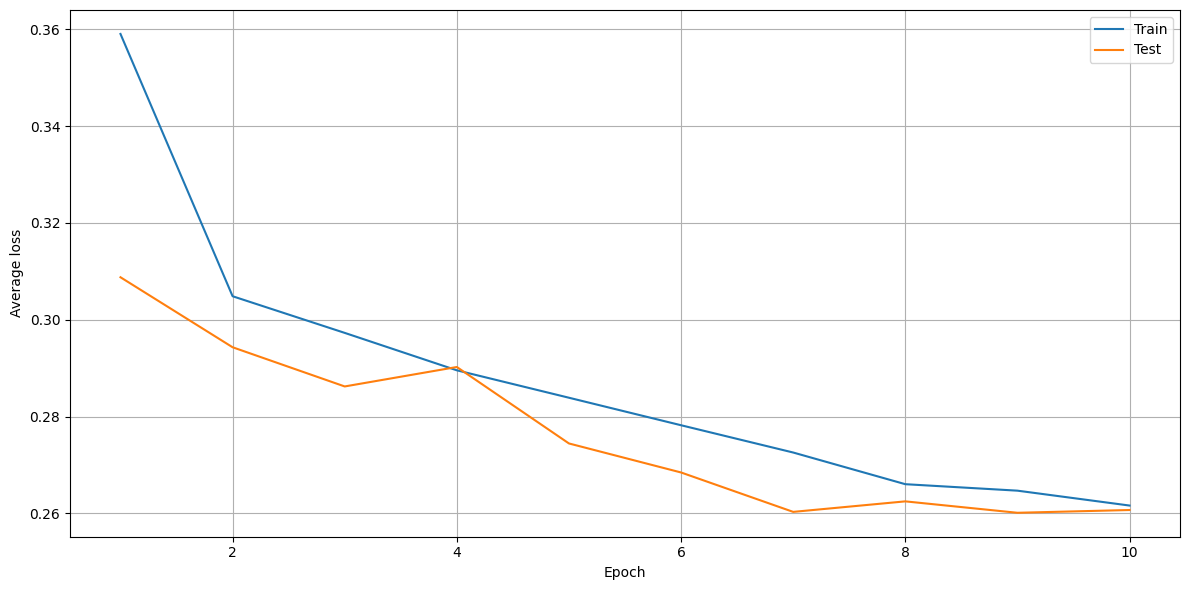

In [ ]:
train_model('GATNet')

### IniMP

In [ ]:
model = UniMP(in_channels=768, hidden_channels=512, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9545705690957088, 'recall': 0.8939289410141428, 'f1-score': 0.9232550544785204, 'support': 17394}, '1': {'precision': 0.8020173838394677, 'recall': 0.9099099099099099, 'f1-score': 0.852563736953174, 'support': 8214}, 'accuracy': 0.8990549828178694, 'macro avg': {'precision': 0.8782939764675883, 'recall': 0.9019194254620264, 'f1-score': 0.8879093957158473, 'support': 25608}, 'weighted avg': {'precision': 0.9056377409289342, 'recall': 0.8990549828178694, 'f1-score': 0.9005801684213041, 'support': 25608}}
Epoch: 001, Train loss: 0.3149, Test loss: 0.2768, Test Acc: 0.8991



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9779016019755588, 'recall': 0.8878923766816144, 'f1-score': 0.9307258866423599, 'support': 17394}, '1': {'precision': 0.8013245033112583, 'recall': 0.9575115656196738, 'f1-score': 0.87248322147651, 'support': 8214}, 'accuracy': 0.9102233676975945, 'macro avg': {'precision': 0.8896130526434085, 'recall': 0.9227019711506441, 'f1-score': 0.901604554059435, 'support': 25608}, 'weighted avg': {'precision': 0.9212628840581671, 'recall': 0.9102233676975945, 'f1-score': 0.9120440195823671, 'support': 25608}}
Epoch: 002, Train loss: 0.2604, Test loss: 0.2296, Test Acc: 0.9102



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9718654051005702, 'recall': 0.891686788547775, 'f1-score': 0.930051269750847, 'support': 17394}, '1': {'precision': 0.8047466058658929, 'recall': 0.9453372291210129, 'f1-score': 0.8693948384929743, 'support': 8214}, 'accuracy': 0.9088956576069979, 'macro avg': {'precision': 0.8883060054832315, 'recall': 0.918512008834394, 'f1-score': 0.8997230541219106, 'support': 25608}, 'weighted avg': {'precision': 0.9182605231529898, 'recall': 0.9088956576069979, 'f1-score': 0.9105951651604, 'support': 25608}}
Epoch: 003, Train loss: 0.2432, Test loss: 0.2210, Test Acc: 0.9089



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9714928732183046, 'recall': 0.8934115212142117, 'f1-score': 0.9308176100628931, 'support': 17394}, '1': {'precision': 0.8071161048689138, 'recall': 0.9444850255661067, 'f1-score': 0.8704140020195221, 'support': 8214}, 'accuracy': 0.9097938144329897, 'macro avg': {'precision': 0.8893044890436093, 'recall': 0.9189482733901593, 'f1-score': 0.9006158060412076, 'support': 25608}, 'weighted avg': {'precision': 0.9187675227332259, 'recall': 0.9097938144329897, 'f1-score': 0.9114426008287378, 'support': 25608}}
Epoch: 004, Train loss: 0.2390, Test loss: 0.2184, Test Acc: 0.9098



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9439751261292972, 'recall': 0.9250891111877659, 'f1-score': 0.9344367015098723, 'support': 17394}, '1': {'precision': 0.8478159308572764, 'recall': 0.8837350864377891, 'f1-score': 0.8654029566046733, 'support': 8214}, 'accuracy': 0.911824429865667, 'macro avg': {'precision': 0.8958955284932868, 'recall': 0.9044120988127775, 'f1-score': 0.8999198290572727, 'support': 25608}, 'weighted avg': {'precision': 0.91313118556524, 'recall': 0.911824429865667, 'f1-score': 0.9122934970170846, 'support': 25608}}
Epoch: 005, Train loss: 0.2328, Test loss: 0.2185, Test Acc: 0.9118



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.957318924169753, 'recall': 0.9065194894791307, 'f1-score': 0.9312269304591761, 'support': 17394}, '1': {'precision': 0.8220422458137244, 'recall': 0.9144144144144144, 'f1-score': 0.8657714252780819, 'support': 8214}, 'accuracy': 0.9090518587941269, 'macro avg': {'precision': 0.8896805849917386, 'recall': 0.9104669519467725, 'f1-score': 0.8984991778686291, 'support': 25608}, 'weighted avg': {'precision': 0.9139276934599585, 'recall': 0.9090518587941269, 'f1-score': 0.9102314790550248, 'support': 25608}}
Epoch: 006, Train loss: 0.2290, Test loss: 0.2120, Test Acc: 0.9091



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9768661905062891, 'recall': 0.8885247786593078, 'f1-score': 0.93060364293241, 'support': 17394}, '1': {'precision': 0.8018800449575968, 'recall': 0.9554419284149014, 'f1-score': 0.871951558246764, 'support': 8214}, 'accuracy': 0.909989065916901, 'macro avg': {'precision': 0.8893731177319429, 'recall': 0.9219833535371046, 'f1-score': 0.9012776005895871, 'support': 25608}, 'weighted avg': {'precision': 0.9207377853384915, 'recall': 0.909989065916901, 'f1-score': 0.9117904508202617, 'support': 25608}}
Epoch: 007, Train loss: 0.2275, Test loss: 0.2100, Test Acc: 0.9100



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9813326419497018, 'recall': 0.8704150856617224, 'f1-score': 0.9225519468649077, 'support': 17394}, '1': {'precision': 0.7785854616895874, 'recall': 0.9649379108838568, 'f1-score': 0.8618027617701424, 'support': 8214}, 'accuracy': 0.9007341455795064, 'macro avg': {'precision': 0.8799590518196446, 'recall': 0.9176764982727896, 'f1-score': 0.8921773543175251, 'support': 25608}, 'weighted avg': {'precision': 0.9162996312242808, 'recall': 0.9007341455795064, 'f1-score': 0.9030660906337142, 'support': 25608}}
Epoch: 008, Train loss: 0.2237, Test loss: 0.2107, Test Acc: 0.9007



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9547869129542437, 'recall': 0.9093365528343107, 'f1-score': 0.93150765606596, 'support': 17394}, '1': {'precision': 0.8255916832559168, 'recall': 0.9088142196250304, 'f1-score': 0.8652063050533148, 'support': 8214}, 'accuracy': 0.9091690096844736, 'macro avg': {'precision': 0.8901892981050803, 'recall': 0.9090753862296705, 'f1-score': 0.8983569805596374, 'support': 25608}, 'weighted avg': {'precision': 0.9133463624722827, 'recall': 0.9091690096844736, 'f1-score': 0.9102408918821945, 'support': 25608}}
Epoch: 009, Train loss: 0.2206, Test loss: 0.2111, Test Acc: 0.9092



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9697992871881448, 'recall': 0.891686788547775, 'f1-score': 0.9291041423308473, 'support': 17394}, '1': {'precision': 0.8040561622464899, 'recall': 0.9411979547114683, 'f1-score': 0.8672387682988391, 'support': 8214}, 'accuracy': 0.9075679475164011, 'macro avg': {'precision': 0.8869277247173173, 'recall': 0.9164423716296217, 'f1-score': 0.8981714553148432, 'support': 25608}, 'weighted avg': {'precision': 0.9166356653406458, 'recall': 0.9075679475164011, 'f1-score': 0.909260258298556, 'support': 25608}}
Epoch: 010, Train loss: 0.2228, Test loss: 0.2098, Test Acc: 0.9076



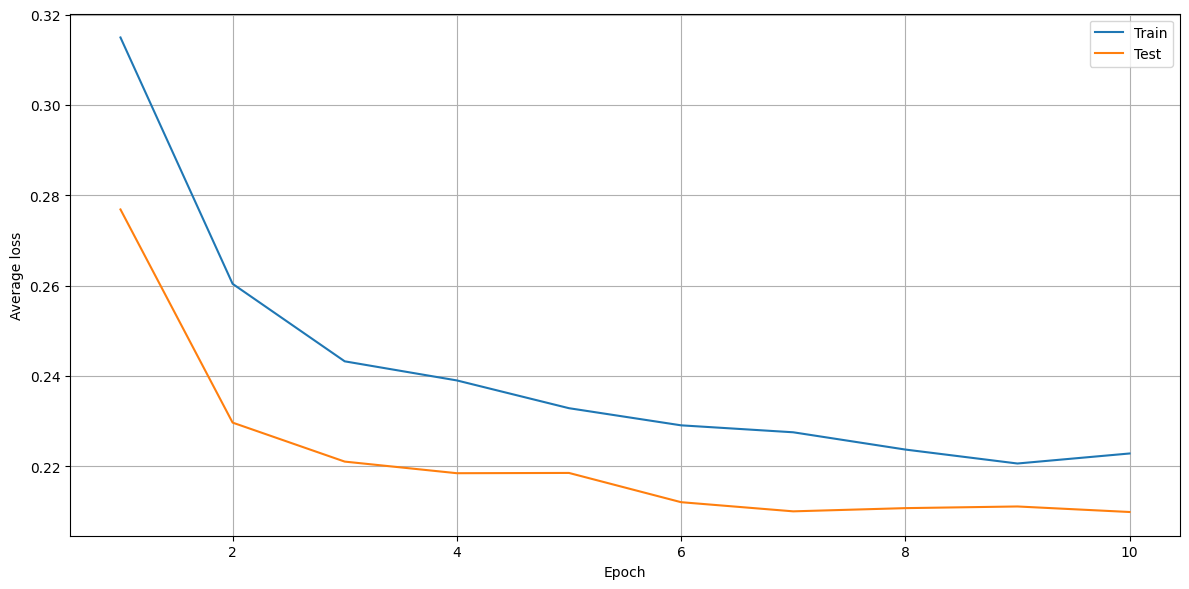

In [ ]:
train_model('UniMP')

### RGGCN

In [ ]:
model = RGGCN(in_channels=768, hidden_channels=512, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9527873615398583, 'recall': 0.9049672300793377, 'f1-score': 0.9282618310482087, 'support': 17394}, '1': {'precision': 0.81809177946517, 'recall': 0.9050401753104456, 'f1-score': 0.8593722906190394, 'support': 8214}, 'accuracy': 0.9049906279287723, 'macro avg': {'precision': 0.8854395705025142, 'recall': 0.9050037026948916, 'f1-score': 0.893817060833624, 'support': 25608}, 'weighted avg': {'precision': 0.9095825227722274, 'recall': 0.9049906279287723, 'f1-score': 0.906164881458815, 'support': 25608}}
Epoch: 001, Train loss: 0.2656, Test loss: 0.1565, Test Acc: 0.9050



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9670145359672009, 'recall': 0.8949637806140048, 'f1-score': 0.9295951271945538, 'support': 17394}, '1': {'precision': 0.8078864353312303, 'recall': 0.9353542731921111, 'f1-score': 0.8669600541638456, 'support': 8214}, 'accuracy': 0.9079194001874414, 'macro avg': {'precision': 0.8874504856492156, 'recall': 0.915159026903058, 'f1-score': 0.8982775906791998, 'support': 25608}, 'weighted avg': {'precision': 0.9159727436123171, 'recall': 0.9079194001874414, 'f1-score': 0.9095043551750974, 'support': 25608}}
Epoch: 002, Train loss: 0.1571, Test loss: 0.1402, Test Acc: 0.9079



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.990582581022277, 'recall': 0.8768540876164195, 'f1-score': 0.9302552529657528, 'support': 17394}, '1': {'precision': 0.7902262266183527, 'recall': 0.9823472120769418, 'f1-score': 0.8758751696065128, 'support': 8214}, 'accuracy': 0.9106919712589816, 'macro avg': {'precision': 0.8904044038203149, 'recall': 0.9296006498466807, 'f1-score': 0.9030652112861328, 'support': 25608}, 'weighted avg': {'precision': 0.9263164495370446, 'recall': 0.9106919712589816, 'f1-score': 0.9128123443156123, 'support': 25608}}
Epoch: 003, Train loss: 0.1457, Test loss: 0.1361, Test Acc: 0.9107



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9910325557216193, 'recall': 0.8767965965275383, 'f1-score': 0.9304212549187079, 'support': 17394}, '1': {'precision': 0.7902925922301595, 'recall': 0.9831994156318481, 'f1-score': 0.8762545434817989, 'support': 8214}, 'accuracy': 0.9109262730396751, 'macro avg': {'precision': 0.8906625739758893, 'recall': 0.9299980060796932, 'f1-score': 0.9033378992002534, 'support': 25608}, 'weighted avg': {'precision': 0.9266433781162284, 'recall': 0.9109262730396751, 'f1-score': 0.9130467872623985, 'support': 25608}}
Epoch: 004, Train loss: 0.1429, Test loss: 0.1335, Test Acc: 0.9109



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9572140512945181, 'recall': 0.9054846498792687, 'f1-score': 0.9306310564878278, 'support': 17394}, '1': {'precision': 0.8204063797247105, 'recall': 0.9142926710494278, 'f1-score': 0.8648088438507602, 'support': 8214}, 'accuracy': 0.9083099031552639, 'macro avg': {'precision': 0.8888102155096143, 'recall': 0.9098886604643482, 'f1-score': 0.8977199501692941, 'support': 25608}, 'weighted avg': {'precision': 0.913331740521541, 'recall': 0.9083099031552639, 'f1-score': 0.9095179803162848, 'support': 25608}}
Epoch: 005, Train loss: 0.1405, Test loss: 0.1345, Test Acc: 0.9083



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9846608048263911, 'recall': 0.8820282856157295, 'f1-score': 0.9305231235784686, 'support': 17394}, '1': {'precision': 0.7953525481200758, 'recall': 0.9709033357682006, 'f1-score': 0.8744038155802861, 'support': 8214}, 'accuracy': 0.9105357700718526, 'macro avg': {'precision': 0.8900066764732335, 'recall': 0.9264658106919651, 'f1-score': 0.9024634695793774, 'support': 25608}, 'weighted avg': {'precision': 0.9239384516326362, 'recall': 0.9105357700718526, 'f1-score': 0.9125223427327535, 'support': 25608}}
Epoch: 006, Train loss: 0.1397, Test loss: 0.1326, Test Acc: 0.9105



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.947107438016529, 'recall': 0.9223870300103484, 'f1-score': 0.9345837944894275, 'support': 17394}, '1': {'precision': 0.8442547300415321, 'recall': 0.890917944971999, 'f1-score': 0.8669588911266437, 'support': 8214}, 'accuracy': 0.912293033427054, 'macro avg': {'precision': 0.8956810840290306, 'recall': 0.9066524874911737, 'f1-score': 0.9007713428080356, 'support': 25608}, 'weighted avg': {'precision': 0.9141164920892162, 'recall': 0.912293033427054, 'f1-score': 0.9128924887950388, 'support': 25608}}
Epoch: 007, Train loss: 0.1386, Test loss: 0.1320, Test Acc: 0.9123



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9761496986996512, 'recall': 0.8847303667931471, 'f1-score': 0.9281944570101633, 'support': 17394}, '1': {'precision': 0.7963019404653053, 'recall': 0.9542244947650353, 'f1-score': 0.8681397795868638, 'support': 8214}, 'accuracy': 0.9070212433614495, 'macro avg': {'precision': 0.8862258195824783, 'recall': 0.9194774307790912, 'f1-score': 0.8981671182985136, 'support': 25608}, 'weighted avg': {'precision': 0.9184618868386344, 'recall': 0.9070212433614495, 'f1-score': 0.9089313704608435, 'support': 25608}}
Epoch: 008, Train loss: 0.1382, Test loss: 0.1449, Test Acc: 0.9070



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9472811278284563, 'recall': 0.9193974933885248, 'f1-score': 0.9331310537985762, 'support': 17394}, '1': {'precision': 0.8393307357322943, 'recall': 0.8916484051619187, 'f1-score': 0.8646989374262102, 'support': 8214}, 'accuracy': 0.9104967197750703, 'macro avg': {'precision': 0.8933059317803753, 'recall': 0.9055229492752217, 'f1-score': 0.8989149956123932, 'support': 25608}, 'weighted avg': {'precision': 0.9126550531378176, 'recall': 0.9104967197750703, 'f1-score': 0.9111808271552376, 'support': 25608}}
Epoch: 009, Train loss: 0.1385, Test loss: 0.1310, Test Acc: 0.9105



  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

{'0': {'precision': 0.9839349718381977, 'recall': 0.8838105093710474, 'f1-score': 0.9311890483978436, 'support': 17394}, '1': {'precision': 0.7975761217948718, 'recall': 0.9694424153883613, 'f1-score': 0.8751511155071985, 'support': 8214}, 'accuracy': 0.9112777257107154, 'macro avg': {'precision': 0.8907555468165347, 'recall': 0.9266264623797044, 'f1-score': 0.903170081952521, 'support': 25608}, 'weighted avg': {'precision': 0.9241586677825948, 'recall': 0.9112777257107154, 'f1-score': 0.9132143693614582, 'support': 25608}}
Epoch: 010, Train loss: 0.1388, Test loss: 0.1322, Test Acc: 0.9113



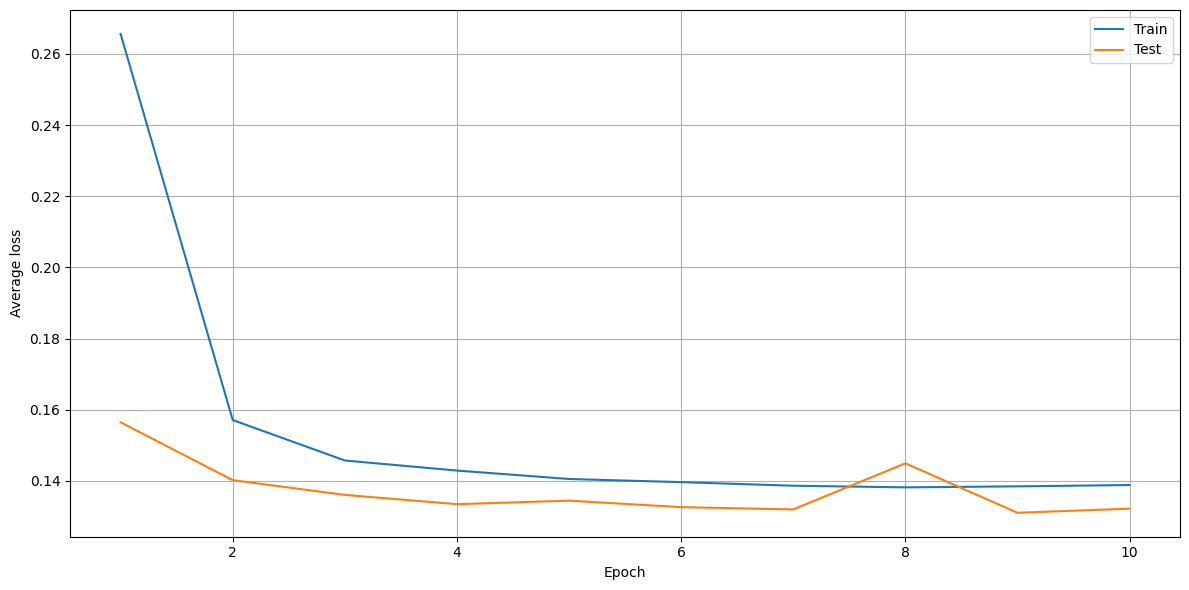

In [ ]:
train_model('RGGCN')

## Summary

In [3]:
with open('reports.pt', 'rb') as f:
  reports = torch.load(f)

In [6]:
index = ['FeaStNet', 'ARMAConv','RGGCN', 'GCN', 'GAT', 'UniMP']
accuracy = []
precision = []
recall = []
F1 = [] 

for name in index:
    accuracy.append(round(reports[name]['accuracy'] * 100, 2))
    precision.append(round(reports[name]['weighted avg']['precision'] * 100, 2))
    recall.append(round(reports[name]['weighted avg']['recall'] * 100, 2))
    F1.append(round(reports[name]['weighted avg']['f1-score'] * 100, 2))

In [7]:
cols = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': F1}
df = pd.DataFrame(data=cols, index=index)
df = df.sort_values(by=['F1'])

In [13]:
df

,Accuracy,Precision,Recall,F1
GAT,88.85,89.53,88.85,89.02
FeaStNet,90.58,91.51,90.58,90.75
UniMP,90.76,91.66,90.76,90.93
ARMAConv,90.91,91.16,90.91,90.99
GCN,91.08,91.64,91.08,91.20
RGGCN,91.13,92.42,91.13,91.32
